In [1]:
import simpletransformers
from simpletransformers.classification import ClassificationModel
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import numpy as np
from scipy.special import softmax
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import scipy.stats as st

In [6]:
orig=pd.read_csv('6.1.21 deidComplete REDCap Reports Non-duplicate Version 3.csv')

In [78]:
def clean_and_featurize(df):
    """Something is happening here to clean the data...."""
    labeled = df
    #labeled = labeled[['Report_ID','Report_Text','MLS_mm']]
    
    #rename columns to relevant
    #labeled = labeled.rename(columns={"Report_ID": "Report_Number"})
    
    # Keep only those with IMPRESSIONS
    labeled = labeled.iloc[[x for x in range(labeled.shape[0]) if 'IMPRESSION:' in labeled.report_text.iloc[x]]]
    
    # replace whitespace with space ***************************
    labeled['text'] = labeled['report_text'].apply(lambda text: ' '.join(text.split()))
    
    #REMOVE HEADER:
    labeled['text'] = labeled.text.apply(lambda text: re.split('-'*78, text, 1)[-1])
    labeled['text'] = labeled.text.apply(lambda text: re.split('HISTORY:', text, 1)[-1])
    labeled['text'] = labeled.text.apply(lambda text: re.split('REPORT ', text, 1)[-1])
    labeled['text'] = labeled.text.apply(lambda text: re.split('REPORT:', text, 1)[-1])
    
    #REMOVE FOOTER:
    # Remove footer parts
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       re.split('electronically signed by:', text, flags=re.IGNORECASE)[0])
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       ''.join(re.split('i, the teaching physician, have reviewed the images and agree with the report as written', text, flags=re.IGNORECASE)))
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       re.split('radiologists: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       re.split('providers: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       re.split('findings were discussed on', text, flags=re.IGNORECASE)[0])
    labeled['text'] = labeled.text.apply(lambda text: 
                                                       re.split('this report was electronically signed by', text, flags=re.IGNORECASE)[0])

    # Remove reference texts =====
    labeled['text'] = labeled.text.apply(lambda text: ''.join([x for i,x in enumerate(text.split('='*34)) if i != 1]))
    
    labeled['text'] = labeled.text.apply(lambda text: text.lower())
    
    
    # Replace ngrams in Report_Text & IMPRESSION with their units
#     for group in wordgroups:
#         labeled['text'] = labeled.text.apply(lambda text: text.replace(group, ''.join(group.split())))

    #labeled = labeled.drop_duplicates(subset=['Report_Number'])
    labeled = labeled.reset_index(drop=True)
    
    return labeled


In [79]:
cleaned_orig=clean_and_featurize(orig)

/home/mattmill/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/mattmill/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/mattmill/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Derive training + testing dataframes for edema

In [255]:
#edema
edema_all=cleaned_orig[np.logical_or(cleaned_orig['edema_report']==0,cleaned_orig['edema_report']==1)]

#MLS
cleaned_orig['mls_mm_v2']=cleaned_orig['mls_mm_v2'].fillna(0)
cleaned_orig['MLS_presence']=cleaned_orig['mls_mm_v2'].apply(lambda x: 0 if x==0 else 1)
mls_all=cleaned_orig[np.logical_or(cleaned_orig['MLS_presence']==0,cleaned_orig['MLS_presence']==1)]

#hemcon
hemcon_all=cleaned_orig[np.logical_or(cleaned_orig['hem_conv_v2']==0,cleaned_orig['hem_conv_v2']==1)]

#severe ECASS (parenchymal hematoma)
#edema_all=cleaned_orig[np.logical_or(cleaned_orig['edema_report']==0,cleaned_orig['edema_report']==1)]

### Derive BWH Edema Training + Testing

In [202]:
#edema_all=edema_all[['text','edema_report']]
edema_all=edema_all.rename(columns={'edema_report':'labels'})

#split data
train_edema,test_edema=train_test_split(edema_all,test_size=0.2)


#critical to weight loss by class imbalance
edema_weights=[(1/train_edema[train_edema.labels==0].shape[0]),(1/train_edema[train_edema.labels==1].shape[0])]


#set proper columns
train_edema=train_edema[['text','labels']].reset_index(drop=True)
train_edema.columns=['text','labels']

test_edema=test_edema[['text','labels']].reset_index(drop=True)
test_edema.columns=['text','labels']


#set CSVs for future training, get train_df and test_df
test_edema.to_csv('test_bwh_edema.csv')
train_edema.to_csv('train_bwh_edema.csv')

train_df=pd.read_csv('train_bwh_edema.csv')
test_df=pd.read_csv('test_bwh_edema.csv')


### Derive BMC Edema Data

In [247]:
bmc_all=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
bmc_all=bmc_all.rename(columns={'Report_Text':'report_text','edema':'labels'})
cleaned_bmc=clean_and_featurize(bmc_all)

test_edema_bmc=cleaned_bmc[['text','labels']].reset_index(drop=True)
test_edema_bmc.to_csv('test_bmc_edema.csv')
test_bmc_df=pd.read_csv('test_bmc_edema.csv')
test_bmc_df=test_bmc_df[np.logical_or(test_bmc_df.labels==0,test_bmc_df.labels==1)]
test_bmc_df.labels.value_counts(dropna=False)

1.0    233
0.0    134
Name: labels, dtype: int64

### Derive BMC ECASS Data

In [346]:
bmc_all=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
bmc_all=bmc_all.rename(columns={'Report_Text':'report_text','ecass':'labels'})
cleaned_bmc=clean_and_featurize(bmc_all)
cleaned_bmc=cleaned_bmc[cleaned_bmc['hemcon']==1]
cleaned_bmc=cleaned_bmc[cleaned_bmc['labels']!=999.0]
# test_edema_bmc=cleaned_bmc[['text','labels']].reset_index(drop=True)
cleaned_bmc['labels']=cleaned_bmc['labels'].apply(lambda x:0 if x<3 else 1)
cleaned_bmc.to_csv('test_bmc_ecass.csv')
# test_edema_bmc.to_csv('test_bmc_edema.csv')
# test_bmc_df=pd.read_csv('test_bmc_edema.csv')
# test_bmc_df=test_bmc_df[np.logical_or(test_bmc_df.labels==0,test_bmc_df.labels==1)]
# test_bmc_df.labels.value_counts(dropna=False)

In [345]:
cleaned_bmc['labels'].value_counts(dropna=False)

0    58
1    23
Name: labels, dtype: int64

### Derive BWH Hemorrhagic Conversion Training + Testing

In [208]:
#hemcon_all=hemcon_all[['text','hemcon_report']]
hemcon_all=hemcon_all.rename(columns={'hem_conv_v2':'labels'})

#split data
train_hemcon,test_hemcon=train_test_split(hemcon_all,test_size=0.2)


#critical to weight loss by class imbalance
hemcon_weights=[(1/train_hemcon[train_hemcon.labels==0].shape[0]),(1/train_hemcon[train_hemcon.labels==1].shape[0])]


#set proper columns
train_hemcon=train_hemcon[['text','labels']].reset_index(drop=True)
train_hemcon.columns=['text','labels']

test_hemcon=test_hemcon[['text','labels']].reset_index(drop=True)
test_hemcon.columns=['text','labels']


#set CSVs for future training, get train_df and test_df
test_hemcon.to_csv('test_bwh_hemcon.csv')
train_hemcon.to_csv('train_bwh_hemcon.csv')

train_df=pd.read_csv('train_bwh_hemcon.csv')
test_df=pd.read_csv('test_bwh_hemcon.csv')


### BMC hemcon data

In [243]:
bmc_all=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
bmc_all=bmc_all.rename(columns={'Report_Text':'report_text','hemcon':'labels'})
cleaned_bmc=clean_and_featurize(bmc_all)

test_hemcon_bmc=cleaned_bmc[['text','labels']].reset_index(drop=True)
test_hemcon_bmc.to_csv('test_bmc_hemcon.csv')
test_bmc_df=pd.read_csv('test_bmc_hemcon.csv')
test_bmc_df=test_bmc_df[np.logical_or(test_bmc_df.labels==0,test_bmc_df.labels==1)]
test_bmc_df.labels.value_counts(dropna=False)

0.0    270
1.0     86
Name: labels, dtype: int64

### Derive BWH MLS

In [267]:
bmc_all=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')

bmc_all['midline_shift_mm'].value_counts(dropna=False)

0.0      251
4.0       16
5.0       15
999.0     14
2.0       11
3.0       11
9.0       10
7.0       10
10.0       9
8.0        7
6.0        5
12.0       4
11.0       2
15.0       2
14.0       2
NaN        1
17.0       1
3.4        1
13.0       1
18.0       1
5.5        1
21.0       1
16.0       1
Name: midline_shift_mm, dtype: int64

In [271]:
bmc_all=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
bmc_all=bmc_all.rename(columns={'Report_Text':'report_text','midline_shift_mm':'labels'})
cleaned_bmc=clean_and_featurize(bmc_all)

test_mls_bmc=cleaned_bmc[['text','labels']].reset_index(drop=True)


test_mls_bmc=test_mls_bmc[test_mls_bmc.labels!=999.0]
test_mls_bmc['labels']=test_mls_bmc['labels'].apply(lambda x:0 if x==0 else 1)

test_mls_bmc.to_csv('test_bmc_mls.csv')
test_bmc_df=pd.read_csv('test_bmc_mls.csv')
test_bmc_df=test_bmc_df[np.logical_or(test_bmc_df.labels==0,test_bmc_df.labels==1)]
test_bmc_df.labels.value_counts(dropna=False)

0    251
1    112
Name: labels, dtype: int64

### Derive BMC MLS

In [ ]:
#mls_all=mls_all[['text','mls_report']]
mls_all=mls_all.rename(columns={'MLS_presence':'labels'})

#split data
train_mls,test_mls=train_test_split(mls_all,test_size=0.2)


#critical to weight loss by class imbalance
mls_weights=[(1/train_mls[train_mls.labels==0].shape[0]),(1/train_mls[train_mls.labels==1].shape[0])]


#set proper columns
train_mls=train_mls[['text','labels']].reset_index(drop=True)
train_mls.columns=['text','labels']

test_mls=test_mls[['text','labels']].reset_index(drop=True)
test_mls.columns=['text','labels']


#set CSVs for future training, get train_df and test_df
test_mls.to_csv('test_bwh_mls.csv')
train_mls.to_csv('train_bwh_mls.csv')

train_df=pd.read_csv('train_bwh_mls.csv')
test_df=pd.read_csv('test_bwh_mls.csv')


### Derive BWH ECASS severity (parenchymal hematoma)

In [287]:
#note that we will be training this outcome only on cases that have ground truth-confirmed hemorrhagic conversion
bwh_ecass=cleaned_orig[cleaned_orig['hem_conv_v2']==1]
bwh_ecass=bwh_ecass[bwh_ecass['ecass_v2']!=999.0]
bwh_ecass['parenchymal_hematoma']=bwh_ecass['ecass_v2'].apply(lambda x:0 if x<3 else 1)
bwh_ecass = bwh_ecass.rename(columns={'parenchymal_hematoma':'labels'})

train_ecass,test_ecass=train_test_split(bwh_ecass,test_size=0.2)


#critical to weight loss by class imbalance
ecass_weights=[(1/train_ecass[train_ecass.labels==0].shape[0]),(1/train_ecass[train_ecass.labels==1].shape[0])]


#set proper columns
train_ecass=train_ecass[['text','labels']].reset_index(drop=True)
train_ecass.columns=['text','labels']

test_ecass=test_ecass[['text','labels']].reset_index(drop=True)
test_ecass.columns=['text','labels']


#set CSVs for future training, get train_df and test_df
test_ecass.to_csv('test_bwh_ecass.csv')
train_ecass.to_csv('train_bwh_ecass.csv')

train_df=pd.read_csv('train_bwh_ecass.csv')
test_df=pd.read_csv('test_bwh_ecass.csv')


#### Bio_ClinicalBERT for *edema* classification; weighted loss implemented

In [288]:
model=ClassificationModel('bert','emilyalsentzer/Bio_ClinicalBERT',
                         num_labels=2,use_cuda=True,weight=ecass_weights,
                         args={'num_train_epochs':5,'output_dir':'ecass_outputs/','max_seq_length':512})

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [289]:
model.train_model(train_df,num_training_epochs=10)

  0%|          | 0/569 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

/home/mattmill/miniconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


Running Epoch 1 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/72 [00:00<?, ?it/s]

(720, 0.27441468144162273)

In [290]:
result,model_outputs,wrong_predictions=model.eval_model(test_df)

  0%|          | 0/143 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

In [291]:
result

{'mcc': 0.5293344420532599,
 'tp': 35,
 'tn': 76,
 'fp': 23,
 'fn': 9,
 'auroc': 0.8581267217630855,
 'auprc': 0.7085657051326562,
 'eval_loss': 1.5335072924693425}

0.7676767676767676

In [123]:
y_true=test_df['labels']
y_score=model_outputs[:,1]

In [125]:
fpr,tpr,_=roc_curve(y_true,y_score)

In [126]:
import matplotlib.pyplot as plt

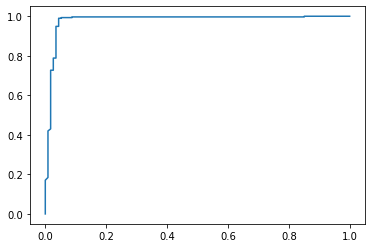

In [127]:
plt.plot(fpr,tpr)

### Collect Stats from Trained Model

In [348]:
def evaluate_BERT_stats(model,test_df,hospital,outcome):
    """Takes in a BERT model that has been fine-tuned on a given task as well as a dataframe of test examples
    (test_df) with columns [text,label] 1) prints important metrics with their 95% CI as well as 
    saves relevant numpy arrays for graphing purposes. Hospital and outcome are strings for saving the uno_numpys
    but of course, they should correspond to the model that is being imported."""

    all_sensitivity=[]
    all_specificity=[]
    all_precision=[]
    all_roc=[]
    all_accuracy=[]


    precisions_4graph=[]
    recalls=[]

    fops=[]
    mpvs=[]


    fprs=[]
    tprs=[]

    for i in range(10):
        bootstrapped=test_df.sample(n=100,replace=True)
        result,model_outputs,wrong_predictions=model.eval_model(bootstrapped)

        tp=result['tp']
        tn=result['tn']
        fp=result['fp']
        fn=result['fn']
        auroc=result['auroc']

        run_sens=tp/(tp+fn)
        run_spec=tn/(tn+fp)
        run_prec=tp/(tp+fp)
        run_acc=(tp+tn)/(tp+tn+fp+fn)

        all_sensitivity.append(run_sens)
        all_specificity.append(run_spec)
        all_precision.append(run_prec)
        all_roc.append(auroc)
        all_accuracy.append(run_acc)


        #
        y_proba=softmax(model_outputs,axis=1)[:,1] #derive the probability of positive class from BERT
        y_true=bootstrapped['labels']


        fop,mpv=calibration_curve(y_true,y_proba,n_bins=10)
        pr_4graph,recall,_=precision_recall_curve(y_true,y_proba)
        fpr,tpr,_=roc_curve(y_true,y_proba)


        #now append
        precisions_4graph.append(pr_4graph)
        recalls.append(recall)

        fops.append(fop)
        mpvs.append(mpv)

        fprs.append(fpr)
        tprs.append(tpr)



        #95 % CIs:
    ci95_acc=st.t.interval(alpha=0.95,df=len(all_accuracy)-1,loc=np.mean(all_accuracy),scale=st.sem(all_accuracy))
    ci95_auc=st.t.interval(alpha=0.95,df=len(all_roc)-1,loc=np.mean(all_roc),scale=st.sem(all_roc))
    ci95_sens=st.t.interval(alpha=0.95,df=len(all_sensitivity)-1,loc=np.mean(all_sensitivity),scale=st.sem(all_sensitivity))
    ci95_spec=st.t.interval(alpha=0.95,df=len(all_specificity)-1,loc=np.mean(all_specificity),scale=st.sem(all_specificity))
    ci95_prec=st.t.interval(alpha=0.95,df=len(all_precision)-1,loc=np.mean(all_precision),scale=st.sem(all_precision))

    
    
    print('Average AUC is {}; 95% CI of AUC is {}'.format(np.mean(all_roc),ci95_auc))
    print('Average sensitivity is {}, 95% CI of sensitivity is {}'.format(np.mean(all_sensitivity),ci95_sens))
    print('Average specificity is {}, 95% CI of specificity is {}'.format(np.mean(all_specificity),ci95_spec))
    print('Average precision is {}, 95% CI of precision is {}'.format(np.mean(all_precision),ci95_prec))
    print('Average accuracy is {}, 95% CI of accuracy is {}'.format(np.mean(all_accuracy),ci95_acc))
    #save uno_numpys from inference model
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_fprs.npy',fprs)
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_tprs.npy',tprs)
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_precisions.npy',precisions_4graph)
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_recalls.npy',recalls)
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_fops.npy',fops)
    np.save(f'uno_numpys/{hospital}_{outcome}_BERT_mpvs.npy',mpvs)
    

In [246]:
edema_model=ClassificationModel("bert","outputs/checkpoint-2040-epoch-10")

In [249]:
result,outputs,_=edema_model.eval_model(test_bmc_df)

  0%|          | 0/367 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

# Part 2: Test Trained Clinical BERTs

In [298]:
edema_BERT=ClassificationModel("bert","outputs/checkpoint-2040-epoch-10")
mls_BERT=ClassificationModel("bert","mls_outputs/checkpoint-2210-epoch-10")
hemcon_BERT=ClassificationModel("bert","hemcon_outputs/checkpoint-1990-epoch-10")
ecass_BERT=ClassificationModel("bert","ecass_outputs/checkpoint-720-epoch-10")


### 2.a.1: BWH Large: Edema

In [306]:
test_df=pd.read_csv('test_bwh_edema.csv')
evaluate_BERT_stats(edema_BERT,test_df,'BWH_LARGE','edema')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9782645017907333; 95% CI of AUC is (0.9657136510676645, 0.9908153525138022)
Average sensitivity is 0.9888194138133674, 95% CI of sensitivity is (0.9809196611808224, 0.9967191664459123)
Average specificity is 0.9213205505843891, 95% CI of specificity is (0.8871693807839723, 0.9554717203848059)
Average precision is 0.969984190636039, 95% CI of precision is (0.9583686044994749, 0.9815997767726031)
Average accuracy is 0.97, 95% CI of accuracy is (0.9604619079206324, 0.9795380920793676)


### 2.a.2: BWH Large: MLS

In [310]:
test_df=pd.read_csv('test_bwh_mls.csv')
evaluate_BERT_stats(mls_BERT,test_df,'BWH_LARGE','MLS')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9994492033854598; 95% CI of AUC is (0.9986951374785474, 1.0002032692923721)
Average sensitivity is 0.981932669331863, 95% CI of sensitivity is (0.9681518507994417, 0.9957134878642843)
Average specificity is 0.9927690969181002, 95% CI of specificity is (0.9853957612958275, 1.000142432540373)
Average precision is 0.9839795807537743, 95% CI of precision is (0.9680958028256873, 0.9998633586818614)
Average accuracy is 0.99, 95% CI of accuracy is (0.9824594761241967, 0.9975405238758033)


### 2.a.3: BWH Large: Hemorrhagic Conversion

In [308]:
test_df=pd.read_csv('test_bwh_hemcon.csv')
evaluate_BERT_stats(hemcon_BERT,test_df,'BWH_LARGE','hemcon')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.968420239627447; 95% CI of AUC is (0.9574084427749926, 0.9794320364799015)
Average sensitivity is 0.8859976576007261, 95% CI of sensitivity is (0.8466008275388465, 0.9253944876626058)
Average specificity is 0.9685305942589342, 95% CI of specificity is (0.9525053558122694, 0.984555832705599)
Average precision is 0.9404933233551654, 95% CI of precision is (0.9088163984477382, 0.9721702482625927)
Average accuracy is 0.9359999999999999, 95% CI of accuracy is (0.9140935127710086, 0.9579064872289913)


### 2.a.4: BWH Large: Parenchymal Hematoma

In [311]:
test_df=pd.read_csv('test_bwh_ecass.csv')
evaluate_BERT_stats(ecass_BERT,test_df,'BWH_LARGE','severe_ecass')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.8609355538060214; 95% CI of AUC is (0.8453660577082689, 0.8765050499037739)
Average sensitivity is 0.809091181806699, 95% CI of sensitivity is (0.7872598842141031, 0.830922479399295)
Average specificity is 0.759663040650471, 95% CI of specificity is (0.7323407029117904, 0.7869853783891515)
Average precision is 0.6001973806832467, 95% CI of precision is (0.5644710415485265, 0.6359237198179669)
Average accuracy is 0.775, 95% CI of accuracy is (0.7552645603747299, 0.7947354396252702)


### 2.b.1: BWH Any: Edema

In [318]:
test_df=pd.read_csv('NL_bwh_edema_BERT.csv')
test_df=test_df[~test_df['labels'].isna()]
evaluate_BERT_stats(edema_BERT,test_df,'BWH_nonLarge','edema')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9640233454061649; 95% CI of AUC is (0.9492912254882685, 0.9787554653240612)
Average sensitivity is 0.9111015768177912, 95% CI of sensitivity is (0.8800198806816815, 0.942183272953901)
Average specificity is 0.9655718583307611, 95% CI of specificity is (0.9522259905613519, 0.9789177261001702)
Average precision is 0.928568669047878, 95% CI of precision is (0.9006703452132325, 0.9564669928825236)
Average accuracy is 0.9479999999999998, 95% CI of accuracy is (0.9350267921872877, 0.960973207812712)


### 2.b.2: BWH Any: MLS

In [320]:
test_df=pd.read_csv('NL_bwh_MLS_BERT.csv')
test_df=test_df[~test_df['labels'].isna()]
evaluate_BERT_stats(mls_BERT,test_df,'BWH_nonLarge','MLS')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9754906265406822; 95% CI of AUC is (0.9521038078223723, 0.9988774452589921)
Average sensitivity is 0.9569108669108669, 95% CI of sensitivity is (0.915538005711411, 0.9982837281103228)
Average specificity is 0.9989010989010989, 95% CI of specificity is (0.9964152119090759, 1.001386985893122)
Average precision is 0.99, 95% CI of precision is (0.9673784283725901, 1.0126215716274098)
Average accuracy is 0.9950000000000001, 95% CI of accuracy is (0.9912297380620985, 0.9987702619379017)


### 2.b.3: BWH Any: Hemorrhagic Conversion

In [322]:
test_df=pd.read_csv('NL_bwh_hemcon_BERT.csv')
test_df=test_df[~test_df['labels'].isna()]
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(hemcon_BERT,test_df,'BWH_nonLarge','hemcon')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9444550070295126; 95% CI of AUC is (0.9316073043584322, 0.957302709700593)
Average sensitivity is 0.7796723756218847, 95% CI of sensitivity is (0.731221623918931, 0.8281231273248385)
Average specificity is 0.9403882193429677, 95% CI of specificity is (0.9222237270674098, 0.9585527116185255)
Average precision is 0.8104502862728669, 95% CI of precision is (0.7499389798699576, 0.8709615926757761)
Average accuracy is 0.9000000000000001, 95% CI of accuracy is (0.8812242469660025, 0.9187757530339977)


### 2.b.4: BWH Any: Parenchymal Hematoma

In [323]:
test_df=pd.read_csv('NL_bwh_ecass_BERT.csv')
test_df=test_df[~test_df['labels'].isna()]
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(ecass_BERT,test_df,'BWH_nonLarge','severe_ecass')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.8949358170015277; 95% CI of AUC is (0.8855747593111809, 0.9042968746918745)
Average sensitivity is 0.8739926739926739, 95% CI of sensitivity is (0.854872260628351, 0.8931130873569968)
Average specificity is 0.7086488356369011, 95% CI of specificity is (0.699678914932304, 0.7176187563414981)
Average precision is 0.3317014382803857, 95% CI of precision is (0.3178186718853788, 0.3455842046753925)
Average accuracy is 0.732, 95% CI of accuracy is (0.7238786072393333, 0.7401213927606667)


### 2.c.1: BMC: Edema

In [324]:
test_df=pd.read_csv('test_bmc_edema.csv')
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(edema_BERT,test_df,'BMC','edema')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9821577574484607; 95% CI of AUC is (0.9783490284285918, 0.9859664864683295)
Average sensitivity is 0.9779103094210253, 95% CI of sensitivity is (0.9683504225826383, 0.9874701962594123)
Average specificity is 0.878541302751829, 95% CI of specificity is (0.8418554666694429, 0.915227138834215)
Average precision is 0.934251118088218, 95% CI of precision is (0.9140358167153689, 0.9544664194610671)
Average accuracy is 0.9419999999999998, 95% CI of accuracy is (0.9277725680059697, 0.9562274319940299)


### 2.c.2: BMC: MLS

In [325]:
test_df=pd.read_csv('test_bmc_mls.csv')
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(mls_BERT,test_df,'BMC','MLS')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9979467104965926; 95% CI of AUC is (0.9949803366165789, 1.0009130843766063)
Average sensitivity is 0.9875767543859648, 95% CI of sensitivity is (0.9714566778850992, 1.0036968308868306)
Average specificity is 1.0, 95% CI of specificity is (nan, nan)
Average precision is 1.0, 95% CI of precision is (nan, nan)
Average accuracy is 0.9960000000000001, 95% CI of accuracy is (0.9909981823162489, 1.0010018176837514)


/home/mattmill/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mattmill/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### 2.c.3: BMC: Hemorrhagic Conversion

In [326]:
test_df=pd.read_csv('test_bmc_hemcon.csv')
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(hemcon_BERT,test_df,'BMC','hemcon')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.9614136318871627; 95% CI of AUC is (0.9522960689368244, 0.9705311948375009)
Average sensitivity is 0.7221809352093327, 95% CI of sensitivity is (0.6860331951113092, 0.7583286753073561)
Average specificity is 0.9876851966561848, 95% CI of specificity is (0.9804535248350716, 0.994916868477298)
Average precision is 0.9561413735454656, 95% CI of precision is (0.9318892235331756, 0.9803935235577556)
Average accuracy is 0.913, 95% CI of accuracy is (0.9040461239983235, 0.9219538760016766)


### 2.c.4: BMC: Parenchymal Hematoma

In [349]:
test_df=pd.read_csv('test_bmc_ecass.csv')
test_df=test_df[np.logical_or(test_df['labels']==0,test_df['labels']==1)]
evaluate_BERT_stats(ecass_BERT,test_df,'BMC','severe_ecass')

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Average AUC is 0.8666722982622466; 95% CI of AUC is (0.8383720593893813, 0.8949725371351118)
Average sensitivity is 0.7944078787460652, 95% CI of sensitivity is (0.751594686306692, 0.8372210711854384)
Average specificity is 0.7442203073474798, 95% CI of specificity is (0.7043120562383818, 0.7841285584565778)
Average precision is 0.5507239258326215, 95% CI of precision is (0.49121980489393424, 0.6102280467713088)
Average accuracy is 0.758, 95% CI of accuracy is (0.7203275547909864, 0.7956724452090136)
